# Auto_RIMA

In [53]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pandas import DataFrame
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from pandas import Series
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score
import pandas as pd
import warnings
import numpy as np
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import itertools
warnings.filterwarnings("ignore")
import matplotlib as mpl
from cycler import cycler
plt.style.use('dark_background')
mpl.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 26
mpl.rcParams['axes.prop_cycle'] = cycler(color=['teal', 'magenta', 'yellow'])

## Load and prepare the data

In [2]:
shoes_raw = pd.read_excel('StockX-Data-Contest-2019-3.xlsx',sheet_name='Raw Data')

## create time-series data

In [3]:
df_shoe = shoes_raw[(shoes_raw['Sneaker Name']=='Air-Jordan-1-Retro-High-Off-White-University-Blue')
                  &(shoes_raw['Shoe Size']>=9)&
                    (shoes_raw['Shoe Size']<=9)]

In [4]:
start_dt = df_shoe['Order Date'].min()
end_dt = df_shoe['Order Date'].max()

df_cal = pd.DataFrame({"cal_date": pd.date_range(start_dt, end_dt)})
df_cal['target_dt'] = df_cal['cal_date'].apply(lambda x: (x + timedelta(20)).strftime('%Y-%m-%d'))
df_cal['lst_window_dt'] = df_cal['cal_date'].apply(lambda x: pd.date_range(x, x + timedelta(13)).strftime('%Y-%m-%d').to_list())
df_cal


def val_at_date(x):
    try:
        val = df_shoe.groupby('Order Date').mean()['Sale Price'][x]
    except:
        return None
    else:
        return val
    
df_cal = pd.DataFrame({"date": pd.date_range(start_dt, end_dt)})
df_cal['price'] = df_cal['date'].apply(val_at_date)
df_cal.interpolate(method='ffill',inplace=True)
mean_price = df_cal[:100]['price'].mean()

In [5]:
df_cal

,date,price
0,2018-05-23,1765.000000
1,2018-05-24,1520.666667
2,2018-05-25,1295.000000
3,2018-05-26,1262.750000
4,2018-05-27,1168.250000
...,...,...
261,2019-02-08,1149.000000
262,2019-02-09,1149.000000
263,2019-02-10,1149.000000
264,2019-02-11,1149.000000


In [6]:
for start in range(100):
    if df_cal['price'][start] <= mean_price:
        break

In [7]:
shoe = df_cal[start:]
shoe.head()

,date,price
14,2018-06-06,1017.666667
15,2018-06-07,1045.000000
16,2018-06-08,1032.500000
17,2018-06-09,1032.500000
18,2018-06-10,1032.500000


In [8]:
series=shoe['price']

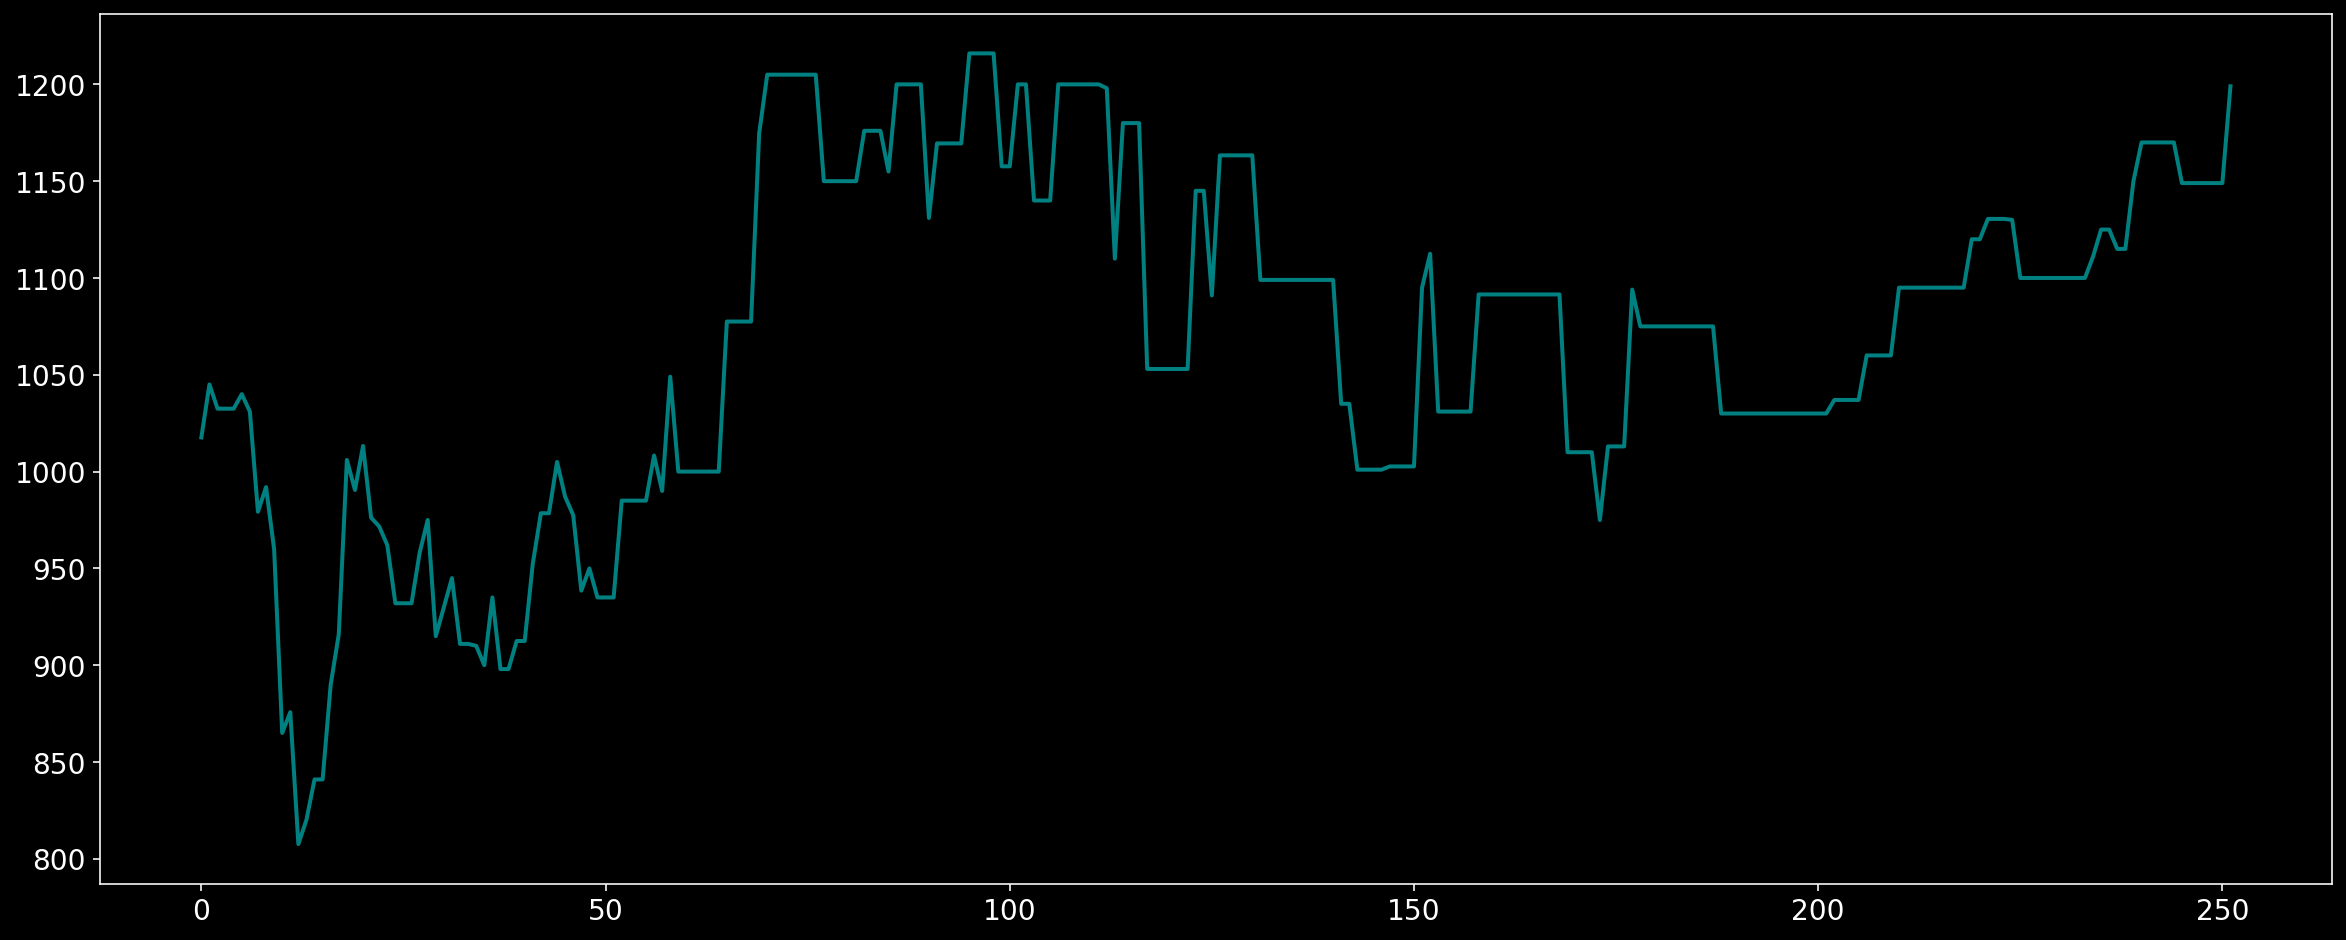

In [9]:
number= np.arange(len(series))
plt.figure(figsize=(20, 8))
plt.plot(number,series) 

## Split Data

In [10]:
split_point = len(series) - 50
dataset, validation = series[0:split_point], series[split_point:]

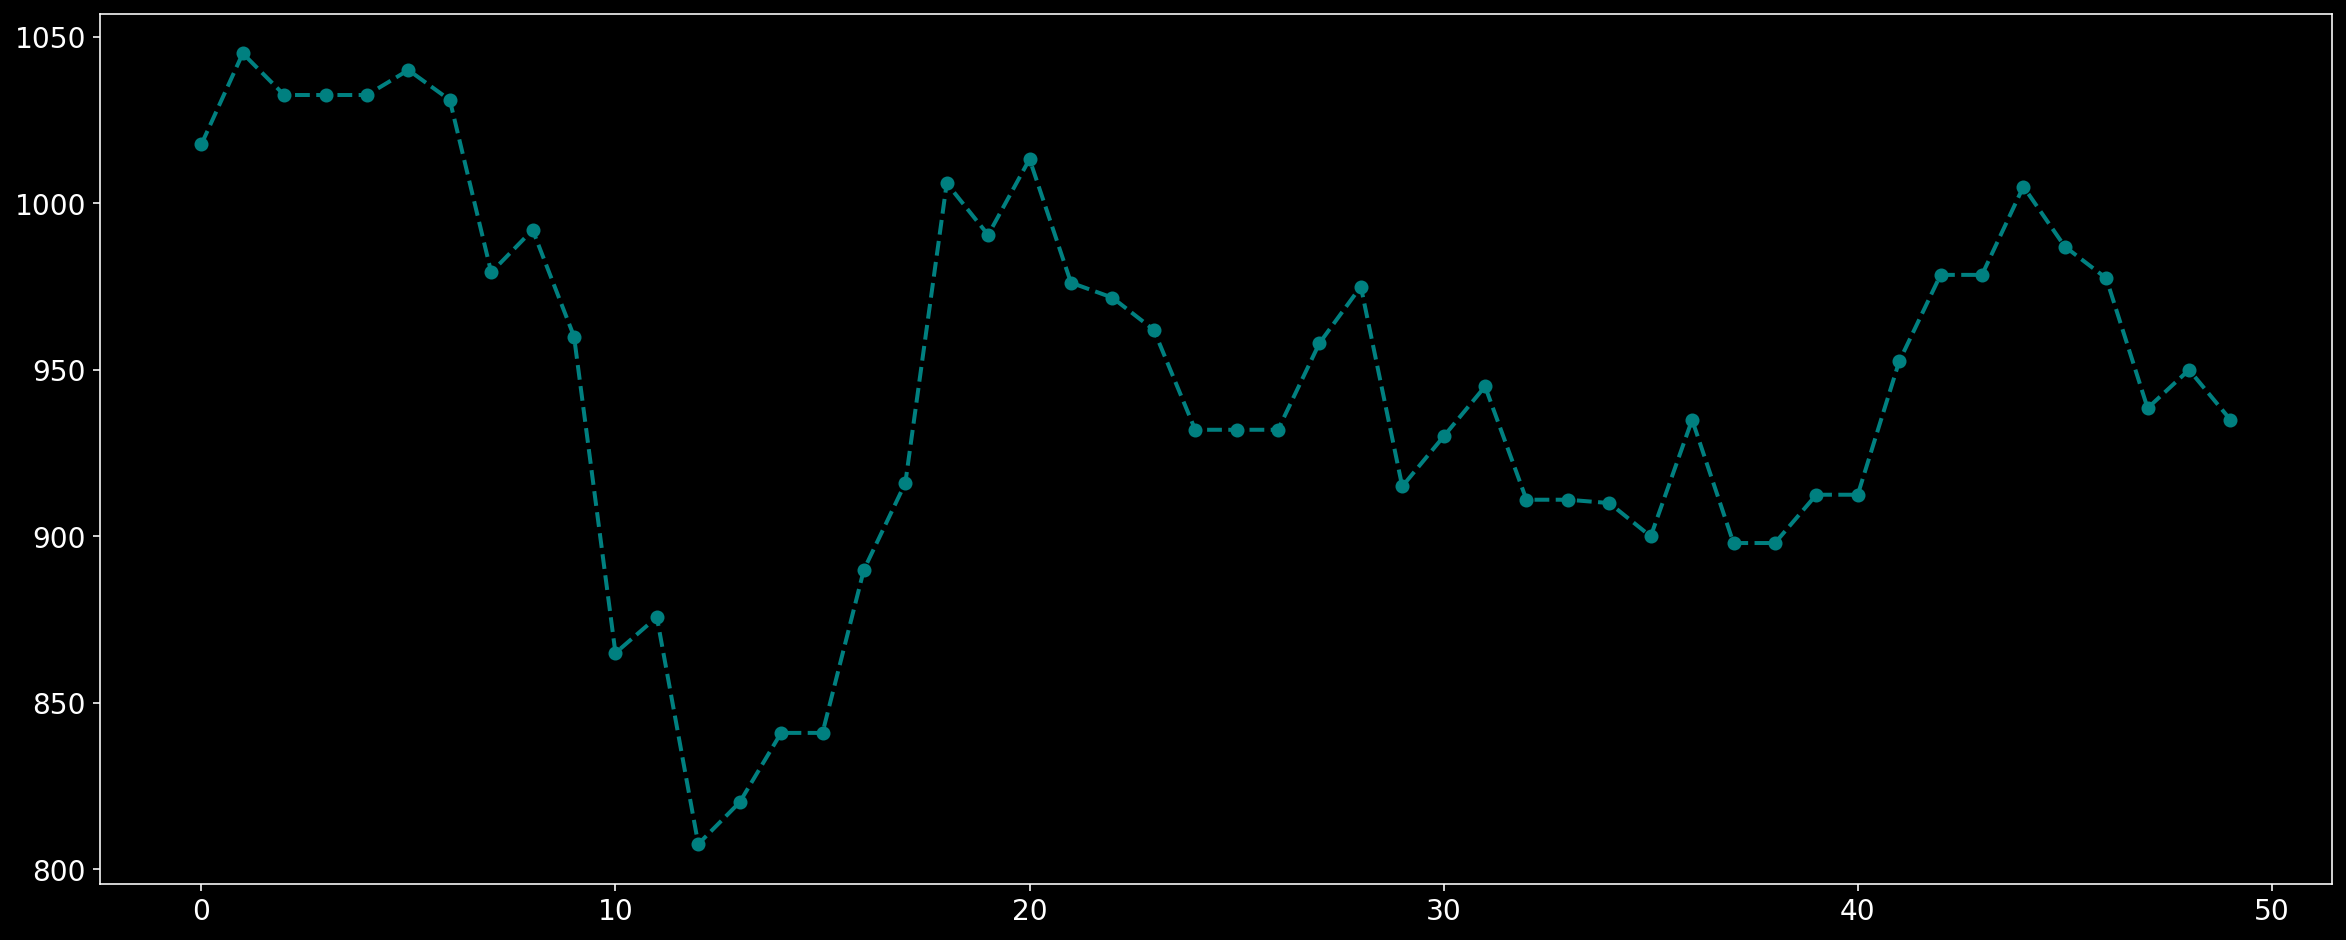

In [11]:
number= np.arange(50)
plt.figure(figsize=(20, 8))
plt.plot(number,dataset[:50] , 'o--') 
HATIAN=0.80

## setup difference

In [12]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = dataset
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * HATIAN)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	days_in_week = 1
	diff = difference(history, days_in_week)
	# predict
	model = ARIMA(diff, order=(1,0,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, days_in_week)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
bias = residuals.describe()[0]['mean']

# eda

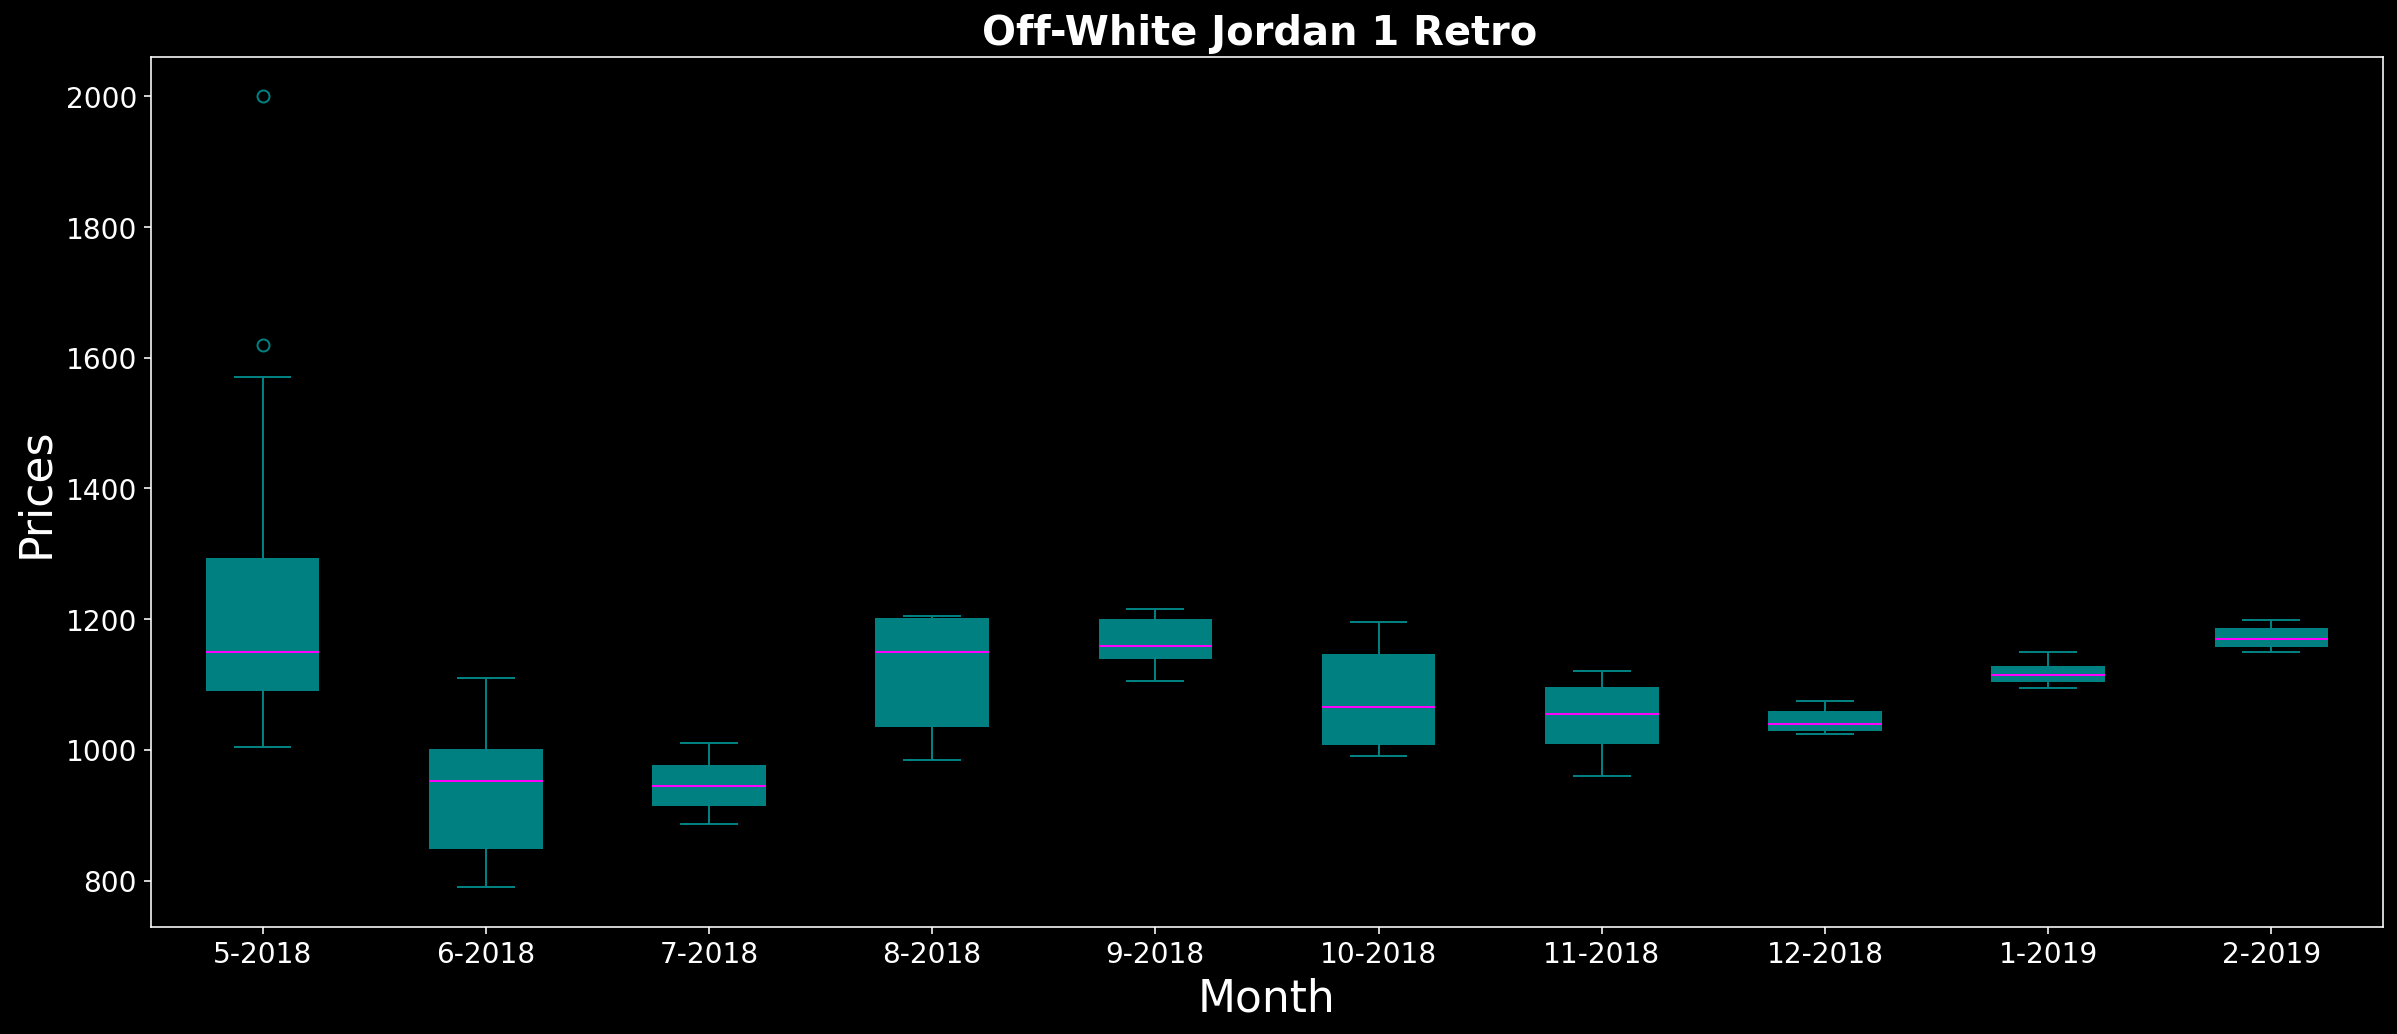

In [13]:
groups = df_shoe.groupby(pd.Grouper(key='Order Date', freq='MS',
                                                label='left'))['Sale Price']

months = dict()
for name, group in groups:
    months[f'{name.month}-{name.year}'] = list(group.values)

plt.figure(figsize=(20, 8))
plt.boxplot(months.values(), patch_artist=True,
            boxprops=dict(color='teal'),
            whiskerprops=dict(color='teal'),
            flierprops=dict(color='teal', markeredgecolor='teal'),
            medianprops=dict(color='magenta'),
            capprops=dict(color='teal'))

plt.title('Off-White Jordan 1 Retro ')
plt.xlabel('Month')
plt.ylabel('Prices')
plt.xticks(range(1, len(months.keys()) + 1), months.keys())


del months
del groups

## get best pdq

In [14]:
p=range(5)
d=range(2)
q=range(5)
pdq = list(itertools.product(p,d,q))
results = []

for order_test in pdq:
    try:
        X = dataset.values.astype('float32')
        history = [x for x in X]
        days_in_week = 1
        y = validation.values.astype('float32')
        # load model
        model = ARIMA(diff, order=order_test)
        model_fit = model.fit(trend='nc', disp=0)
        #bias=0 # do not load the bias
        # make first prediction
        predictions = list()
        yhat = float(model_fit.forecast()[0])
        yhat = bias + inverse_difference(history, yhat, days_in_week)
        predictions.append(yhat)
        history.append(y[0])
        for i in range(1, len(y)):
            # difference data
            days_in_week = 1
            diff = difference(history, days_in_week)
            # predict
            model = ARIMA(diff, order=order_test)
            model_fit = model.fit(trend='nc', disp=0)
            yhat = model_fit.forecast()[0]
            yhat = bias + inverse_difference(history, yhat, days_in_week)
            predictions.append(yhat)
            # observation
            obs = y[i]
            history.append(obs)
    #         print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
        # report performance
        mse = mean_squared_error( y,predictions)
        mae = mean_absolute_error( y,predictions)
        rmse = sqrt(mse)
    #     print('p,d,q:',order_test)
    #     print('RMSE: %.3f' % rmse)
        r2 = r2_score( y,predictions)
    #     print("R2 score = %f"%r2)
        results.append([order_test,rmse,r2,mae])
    except:
        continue

best_values = sorted(results,key=lambda x: x[3])[0]
best_order = best_values[0]
print(best_order)

(0, 1, 1)


## plot results

### 7 days

MAE: 5.783366027252506
R2: 0.24699594923382306
RMSE: 9.877


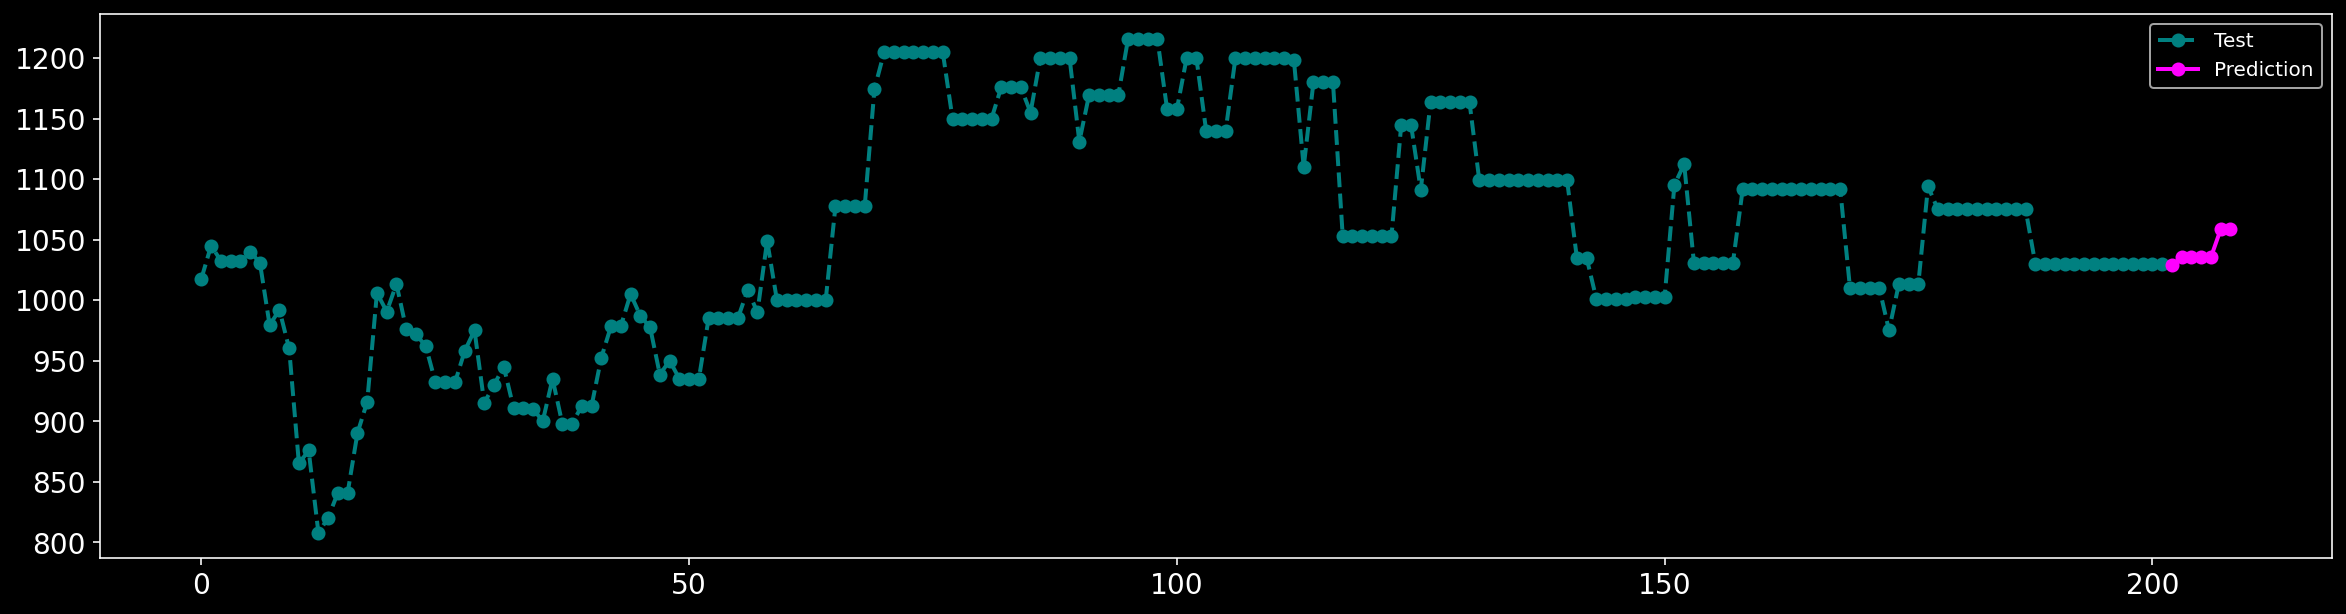

In [50]:
X = dataset.values.astype('float32')
history = [x for x in X]
days_in_week = 1
#validation = Series.from_csv('validation.csv')
y_7 = validation.iloc[:7].values.astype('float32')
# load model
model = ARIMA(diff, order=best_order)
model_fit = model.fit(trend='nc', disp=0)
#bias=0 # do not load the bias
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, days_in_week)
predictions.append(yhat)
history.append(y_7[0])
# rolling forecasts
for i in range(1, len(y_7)):
	# difference data
	days_in_week = 1
	diff = difference(history, days_in_week)
	# predict
	model = ARIMA(diff, order=best_order)
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, days_in_week)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
# report performance
mse = mean_squared_error(y_7, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_7, predictions)
print('MAE:',mae)
print('R2:',r2_score(y_7, predictions))
print('RMSE: %.3f' % rmse)
fig = plt.figure(figsize=(20, 5)) 
plt.plot(X[:split_point+7],'o--',label='Test')
plt.plot([None]*split_point+predictions, 'o-',label='Prediction')
plt.legend()
plt.show()

### 30 days

MAE: 5.582821949115707
R2: 0.8462155597579958
RMSE: 11.110


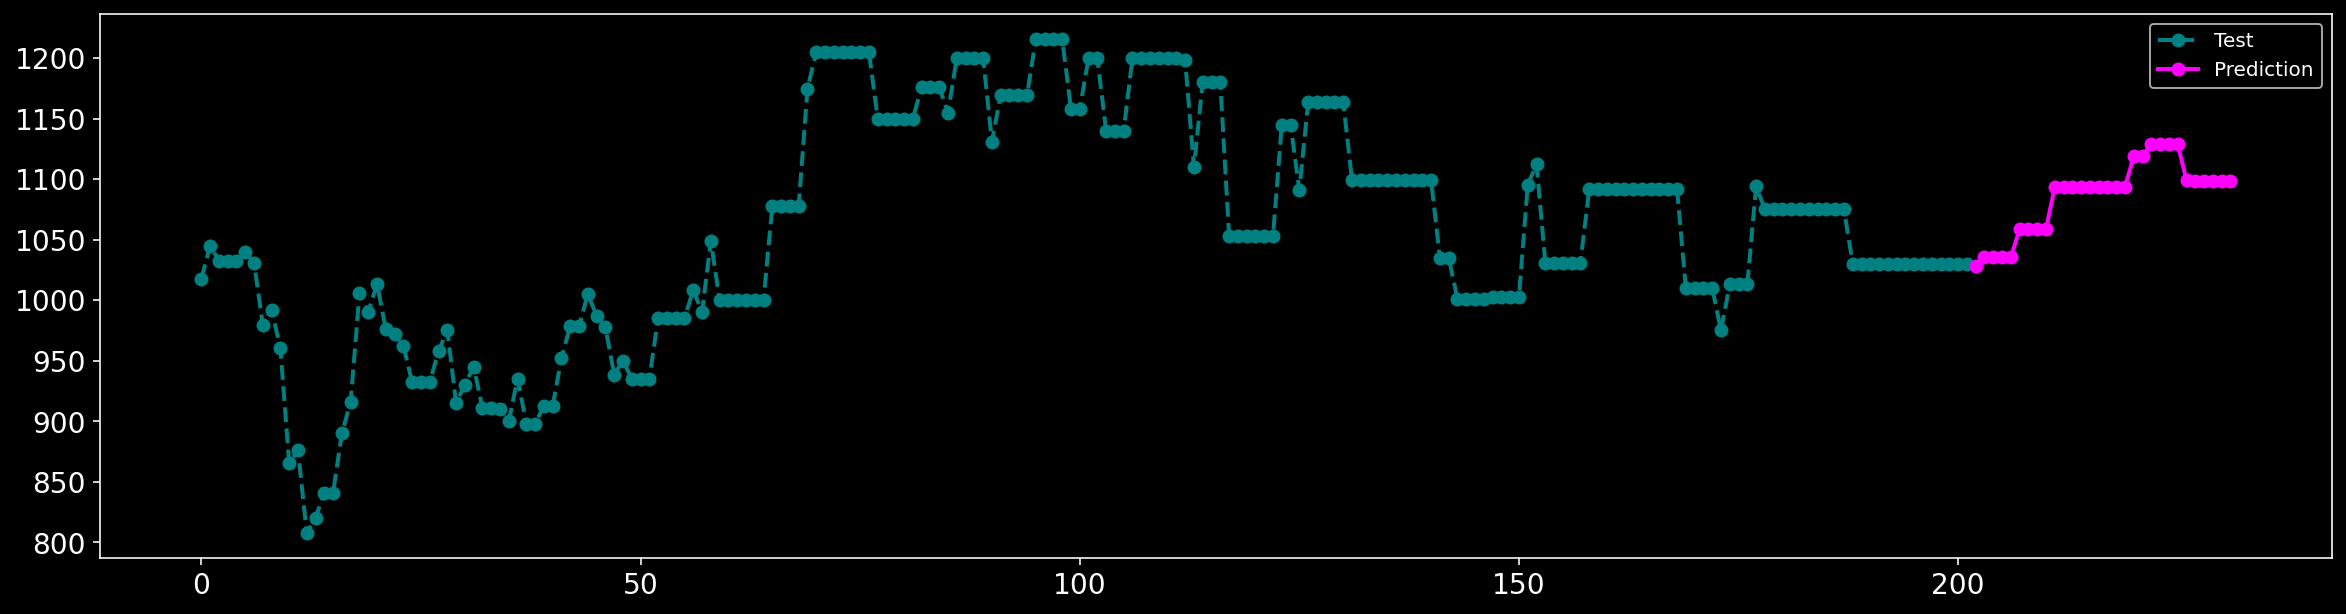

In [51]:
X = dataset.values.astype('float32')
history = [x for x in X]
days_in_week = 1
#validation = Series.from_csv('validation.csv')
y_30 = validation.iloc[:30].values.astype('float32')
# load model
model = ARIMA(diff, order=best_order)
model_fit = model.fit(trend='nc', disp=0)
#bias=0 # do not load the bias
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, days_in_week)
predictions.append(yhat)
history.append(y_30[0])
# rolling forecasts
for i in range(1, len(y_30)):
	# difference data
	days_in_week = 1
	diff = difference(history, days_in_week)
	# predict
	model = ARIMA(diff, order=best_order)
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, days_in_week)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
# report performance
mse = mean_squared_error(y_30, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_30, predictions)
print('MAE:',mae)
print('R2:',r2_score(y_30, predictions))
print('RMSE: %.3f' % rmse)
fig = plt.figure(figsize=(20, 5)) 
plt.plot(X[:split_point+30],'o--',label='Test')
plt.plot([None]*split_point+predictions, 'o-',label='Prediction')
plt.legend()
plt.show()

### 50-days

MAE: 6.933578756195134
R2: 0.8775226545732802
RMSE: 13.381


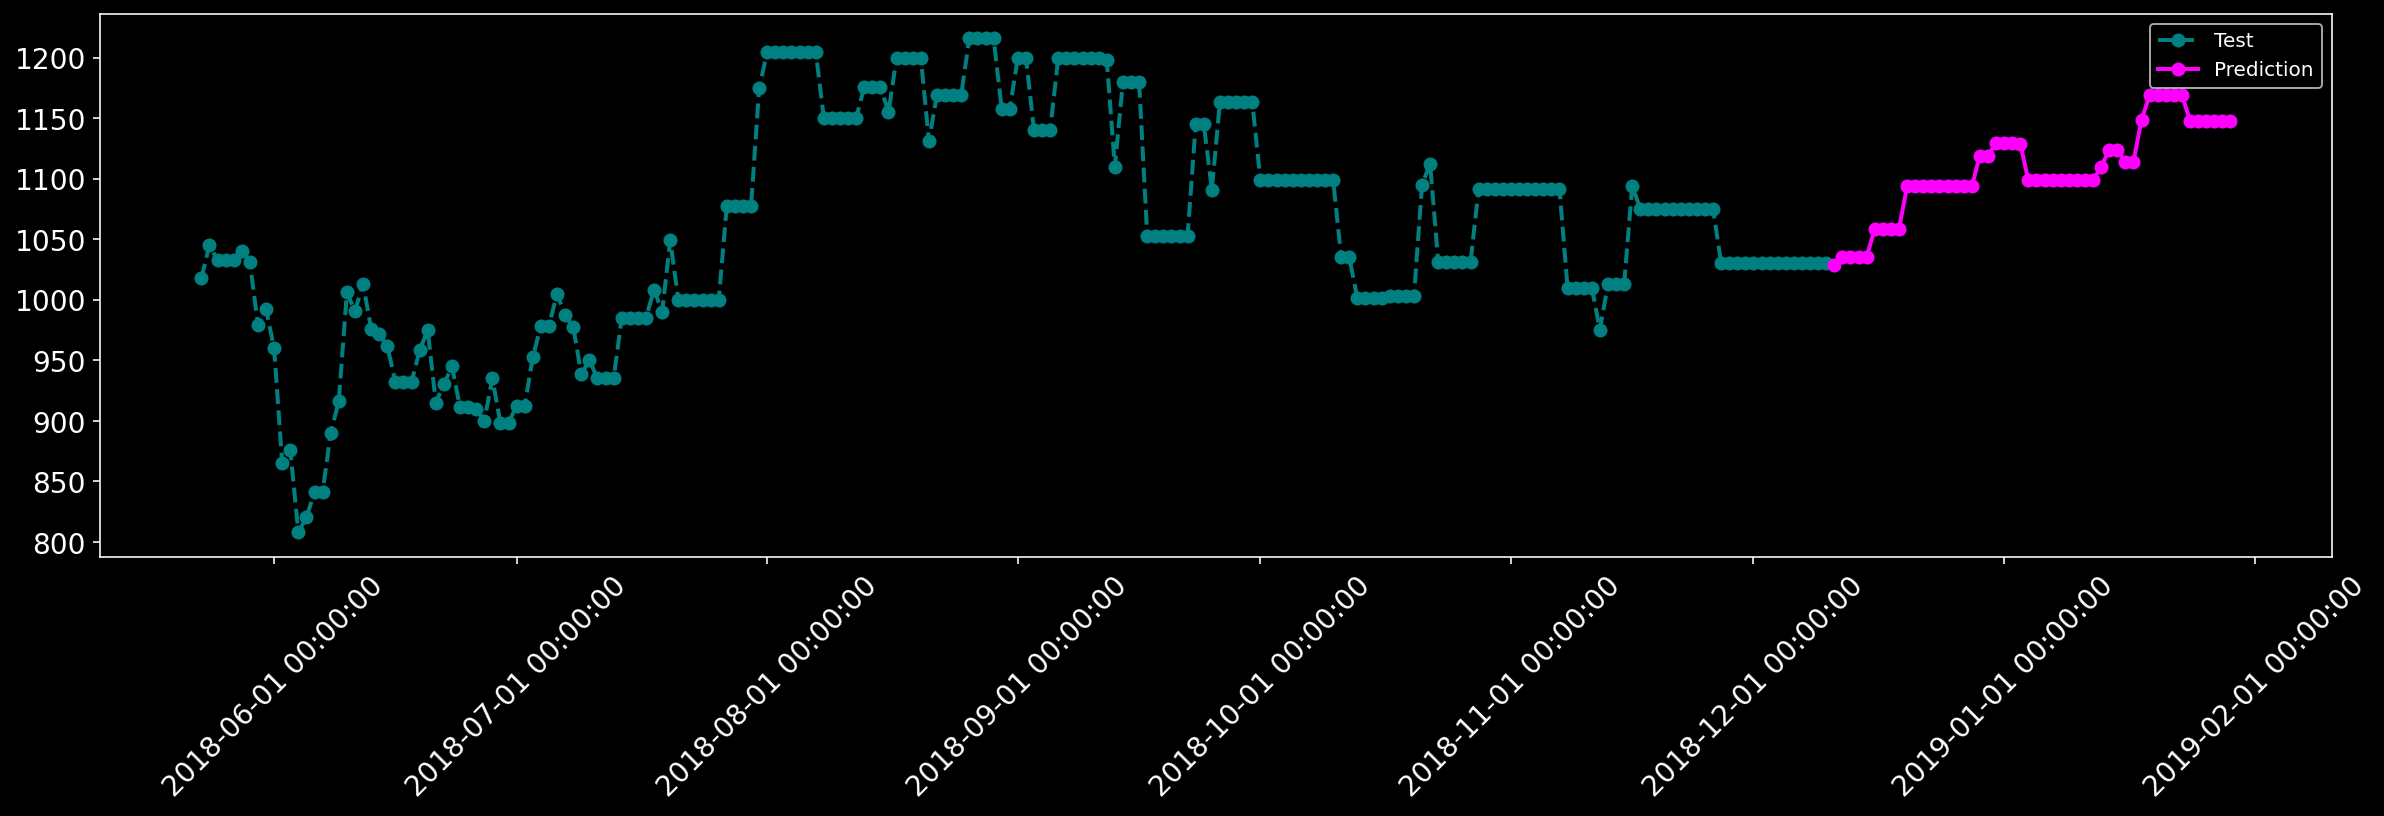

In [80]:
X = dataset.values.astype('float32')
history = [x for x in X]
days_in_week = 1
#validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model = ARIMA(diff, order=best_order)
model_fit = model.fit(trend='nc', disp=0)
#bias=0 # do not load the bias
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, days_in_week)
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	days_in_week = 1
	diff = difference(history, days_in_week)
	# predict
	model = ARIMA(diff, order=best_order)
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, days_in_week)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y, predictions)
print('MAE:',mae)
print('R2:',r2_score(y, predictions))
print('RMSE: %.3f' % rmse)
fig = plt.figure(figsize=(20, 5)) 
plt.plot(X,'o--',label='Test')
plt.plot([None]*split_point+predictions, 'o-',label='Prediction')
plt.xticks(ticks=[9,39,70,101,131,162,192,223,254],labels=df_cal.date[[9,39,70,101,131,162,192,223,254]],rotation=45)
plt.legend()
plt.show()

In [78]:
df_cal.date[[9,39,70,101,131,162,192,223,254]]

9     2018-06-01
39    2018-07-01
70    2018-08-01
101   2018-09-01
131   2018-10-01
162   2018-11-01
192   2018-12-01
223   2019-01-01
254   2019-02-01
Name: date, dtype: datetime64[ns]